In [57]:
#Data Reading#

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
boston_df = pd.read_csv("boston.csv")

print(boston_df.head())

boston_df.info()

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-nu

In [11]:
boston_df.shape


(506, 14)

In [59]:
#DataCleaning#

In [19]:
boston_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [23]:
target_column_name = 'MEDV'
X = boston_df.drop(target_column_name, axis=1)
y = boston_df[target_column_name]
print(f"\nFeatures (X) and target (y = '{target_column_name}') separated.")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Feature columns:", X.columns.tolist())

X = X.astype(float)
y = y.astype(float)



Features (X) and target (y = 'MEDV') separated.
X shape: (506, 13)
y shape: (506,)
Feature columns: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


In [61]:
# Ridge And Lasso Models#

In [27]:
def normalize_features(X_train, X_test):
    X_mean = X_train.mean(axis=0)
    X_std = X_train.std(axis=0)

    X_std[X_std == 0] = 1.0

    X_train_norm = (X_train - X_mean) / X_std
    X_test_norm = (X_test - X_mean) / X_std

    X_train_norm = np.nan_to_num(X_train_norm, nan=0.0)
    X_test_norm = np.nan_to_num(X_test_norm, nan=0.0)

    return X_train_norm, X_test_norm, X_mean, X_std

In [29]:
def train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True):
    if len(arrays) == 0:
        raise ValueError("At least one array required.")
    n_samples = len(arrays[0])
    for arr in arrays:
        if len(arr) != n_samples:
            raise ValueError("All input arrays must have the same length.")
    if isinstance(random_state, int):
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random if random_state is None else random_state
    if test_size is None and train_size is None:
        test_size = 0.25
    if test_size is not None:
        n_test = int(np.ceil(test_size * n_samples)) if isinstance(test_size, float) else int(test_size)
    else:
        n_test = n_samples - int(train_size)
    n_train = n_samples - n_test
    indices = rng.permutation(n_samples) if shuffle else np.arange(n_samples)
    train_indices = indices[:n_train]
    test_indices = indices[n_train:]
    result = []
    for arr in arrays:
        arr_np = np.array(arr)
        result.append(arr_np[train_indices])
        result.append(arr_np[test_indices])
    return result


X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, X_mean, X_std = normalize_features(X_train_raw, X_test_raw)

In [31]:
def predict_linear(X, w, b):
    return np.dot(X, w) + b


def calculate_r2_score(y_true, y_pred):
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    if ss_tot == 0:
        return 1.0 if ss_res == 0 else 0.0
    return 1 - (ss_res / ss_tot)

In [37]:
def compute_cost_linear(X, y, w, b):
    m = X.shape[0]
    cost = np.sum((np.dot(X, w) + b - y)**2) / (2 * m)
    return cost

def compute_gradient_linear(X, y, w, b):
    m, n = X.shape
    err = (np.dot(X, w) + b) - y
    dj_dw = np.dot(X.T, err) / m
    dj_db = np.sum(err) / m
    return dj_dw, dj_db

In [39]:
def compute_cost_ridge(X, y, w, b, lambda_):
    m = X.shape[0]
    linear_cost = compute_cost_linear(X, y, w, b)
    reg_cost = (lambda_ / (2 * m)) * np.sum(w**2)
    return linear_cost + reg_cost

def compute_gradient_ridge(X, y, w, b, lambda_):
    m, n = X.shape
    dj_dw_linear, dj_db = compute_gradient_linear(X, y, w, b)
    dj_dw_ridge = dj_dw_linear + (lambda_ / m) * w
    return dj_dw_ridge, dj_db

In [35]:
def compute_cost_lasso(X, y, w, b, lambda_):
    m = X.shape[0]
    linear_cost = compute_cost_linear(X, y, w, b)
    reg_cost = (lambda_ / (2 * m)) * np.sum(np.abs(w))
    return linear_cost + reg_cost

def compute_gradient_lasso(X, y, w, b, lambda_):
    m, n = X.shape
    err = (np.dot(X, w) + b) - y

    dj_dw = (1/m) * np.dot(X.T, err)
    dj_db = (1/m) * np.sum(err)

    dj_dw_lasso = dj_dw + (lambda_ / m) * np.sign(w)

    return dj_dw_lasso, dj_db

In [41]:
def gradient_descent_reg(X, y, w_init, b_init, learning_rate, iterations, lambda_, model_type):
    w = w_init
    b = b_init
    cost_history = []

    for i in range(iterations):
        if model_type == 'ridge':
            dj_dw, dj_db = compute_gradient_ridge(X, y, w, b, lambda_)
            cost = compute_cost_ridge(X, y, w, b, lambda_)
        elif model_type == 'lasso':
            dj_dw, dj_db = compute_gradient_lasso(X, y, w, b, lambda_)
            cost = compute_cost_lasso(X, y, w, b, lambda_)
        else:
            raise ValueError("model_type must be 'ridge' or 'lasso'")

        w = w - learning_rate * dj_dw
        b = b - learning_rate * dj_db

        cost_history.append(cost)

    return w, b, cost_history

In [63]:
print("\nTraining Ridge Regression Model ")


w_init_ridge = np.zeros(X_train.shape[1])
b_init_ridge = 0
learning_rate = 0.01
iterations = 5000
lambda_ridge = 10.0

w_ridge, b_ridge, cost_history_ridge = gradient_descent_reg(
    X_train, y_train, w_init_ridge, b_init_ridge, learning_rate, iterations, lambda_ridge, 'ridge'
)

y_pred_train_ridge = predict_linear(X_train, w_ridge, b_ridge)
y_pred_test_ridge = predict_linear(X_test, w_ridge, b_ridge)

r2_train_ridge = calculate_r2_score(y_train, y_pred_train_ridge)
r2_test_ridge = calculate_r2_score(y_test, y_pred_test_ridge)

print(f"\nRidge Regression (Lambda={lambda_ridge}):")
print(f"  Training R² Score: {r2_train_ridge:.4f}")
print(f"  Test R² Score: {r2_test_ridge:.4f}")
print(f"  Final Bias (b): {b_ridge:.4f}")



Training Ridge Regression Model 

Ridge Regression (Lambda=10.0):
  Training R² Score: 0.7486
  Test R² Score: 0.6911
  Final Bias (b): 22.5057


In [65]:
print("\nTraining Lasso Regression Model")


w_init_lasso = np.zeros(X_train.shape[1])
b_init_lasso = 0
lambda_lasso = 0.1

w_lasso, b_lasso, cost_history_lasso = gradient_descent_reg(
    X_train, y_train, w_init_lasso, b_init_lasso, learning_rate, iterations, lambda_lasso, 'lasso'
)

y_pred_train_lasso = predict_linear(X_train, w_lasso, b_lasso)
y_pred_test_lasso = predict_linear(X_test, w_lasso, b_lasso)

r2_train_lasso = calculate_r2_score(y_train, y_pred_train_lasso)
r2_test_lasso = calculate_r2_score(y_test, y_pred_test_lasso)

print(f"\nLasso Regression (Lambda={lambda_lasso}):")
print(f"  Training R² Score: {r2_train_lasso:.4f}")
print(f"  Test R² Score: {r2_test_lasso:.4f}")
print(f"  Final Bias (b): {b_lasso:.4f}")



Training Lasso Regression Model

Lasso Regression (Lambda=0.1):
  Training R² Score: 0.7500
  Test R² Score: 0.6877
  Final Bias (b): 22.5057


In [55]:
#Related Plots#

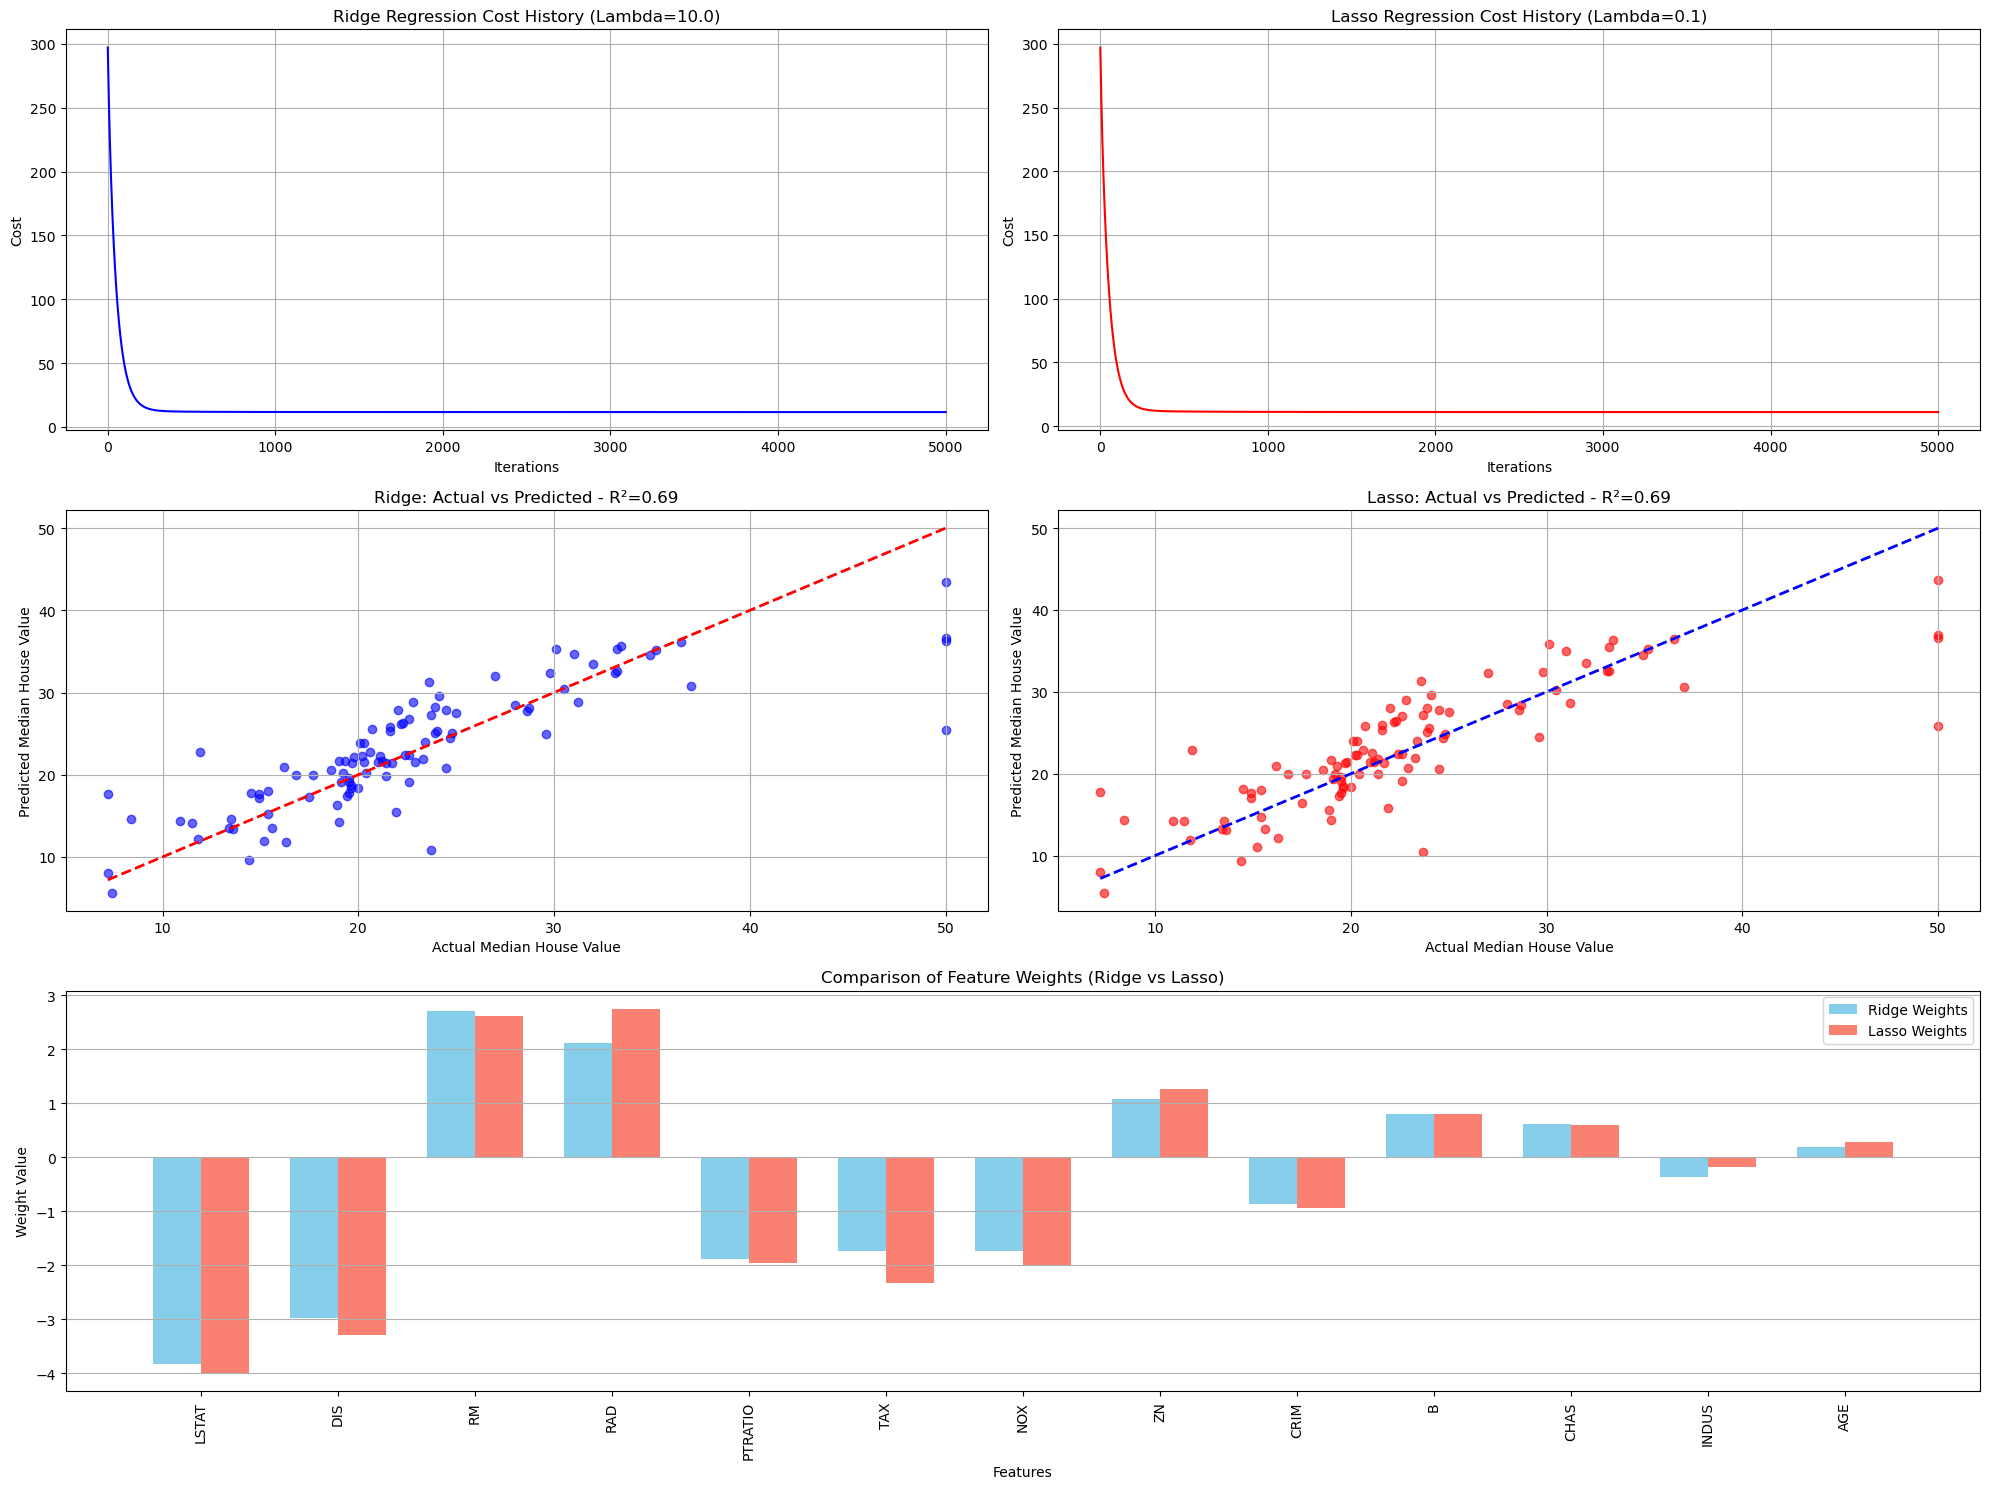

In [67]:
plt.figure(figsize=(20, 15))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.subplot(3, 2, 1)
plt.plot(range(1, iterations + 1), cost_history_ridge, color='blue')
plt.title(f'Ridge Regression Cost History (Lambda={lambda_ridge})')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(range(1, iterations + 1), cost_history_lasso, color='red')
plt.title(f'Lasso Regression Cost History (Lambda={lambda_lasso})')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.grid(True)


plt.subplot(3, 2, 3)
plt.scatter(y_test, y_pred_test_ridge, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Ridge: Actual vs Predicted - R²={r2_test_ridge:.2f}')
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.scatter(y_test, y_pred_test_lasso, alpha=0.6, color='red')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2)
plt.title(f'Lasso: Actual vs Predicted - R²={r2_test_lasso:.2f}')
plt.xlabel('Actual Median House Value')
plt.ylabel('Predicted Median House Value')
plt.grid(True)

plt.subplot(3, 1, 3)
feature_names = X.columns.tolist()

weights_df = pd.DataFrame({
    'Feature': feature_names,
    'Ridge Weights': w_ridge,
    'Lasso Weights': w_lasso
})

weights_df['Abs_Ridge_Weights'] = np.abs(weights_df['Ridge Weights'])
weights_df = weights_df.sort_values(by='Abs_Ridge_Weights', ascending=False)

x = np.arange(len(weights_df))
width = 0.35

plt.bar(x - width/2, weights_df['Ridge Weights'], width, label='Ridge Weights', color='skyblue')
plt.bar(x + width/2, weights_df['Lasso Weights'], width, label='Lasso Weights', color='salmon')

plt.xlabel('Features')
plt.ylabel('Weight Value')
plt.title('Comparison of Feature Weights (Ridge vs Lasso)')
plt.xticks(x, weights_df['Feature'], rotation=90)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

plt.show()